In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../")
from src import soporte_clustering as s_clustering, soporte_eda_y_outliers as s_eda, soporte_encoding as s_encoding, soporte_tests_y_encoding as s_tests, soporte_scaling as s_estandarizacion

import seaborn as sns
import matplotlib.pyplot as plt 
import math



In [3]:
df = pd.read_pickle("../datos/df_investigado")

In [4]:
df_ventas = df[["Order_Date","Ship_Date","Ship_Mode","Segment","Market","Sub-Category","Product_Name","Sales","Quantity","Discount","Profit","Shipping_Cost","Order_Priority"]]

# Encoding alternativo

In [5]:
def target_encoding_multiple(df, columns, target_column):
    for column in columns:
        encoder = TargetEncoder(cols=[column])
        df[f'{column}_target'] = encoder.fit_transform(df[column], df[target_column])
    return df

In [6]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import OrdinalEncoder

# Copiar el DataFrame original
df_limpio2 = df_ventas.copy()
df_limpio2.drop(columns = ["Order_Date","Ship_Date","Product_Name"],inplace= True)

# Seleccionar columnas categóricas
cols_cat = df_limpio2.select_dtypes(include="O").columns.tolist()

# Columnas para aplicar Ordinal Encoding
cols_ordinal = ["Ship_Mode", "Order_Priority"]

df_limpio2["Discount"] = df_limpio2["Discount"]*10
# Filtrar columnas para Target Encoding
cols_target = [col for col in cols_cat if col not in cols_ordinal]

# Aplicar Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
df_limpio2[cols_ordinal] = ordinal_encoder.fit_transform(df_limpio2[cols_ordinal])

# Aplicar Target Encoding
df_encoded2 = target_encoding_multiple(df_limpio2, cols_target, target_column="Sales")

# Mostrar el DataFrame resultante
df_encoded2.head()


,Ship_Mode,Segment,Market,Sub-Category,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Segment_target,Market_target,Sub-Category_target
0,1.0,Consumer,US,Accessories,2309.650,7,0.0,762.1845,933.57,0.0,245.416299,229.858001,243.654315
1,2.0,Corporate,APAC,Chairs,3709.395,9,1.0,-288.7650,923.63,0.0,247.890176,325.917481,437.298126
2,0.0,Consumer,APAC,Phones,5175.171,9,1.0,919.9710,915.49,3.0,245.416299,325.917481,508.437337
3,0.0,Home Office,EU,Phones,2892.510,5,1.0,-96.5400,910.16,3.0,247.228403,293.808906,508.437337
4,1.0,Consumer,Africa,Copiers,2832.960,8,0.0,311.5200,903.04,0.0,245.416299,170.868370,679.008670


In [7]:
df_limpio2.drop(columns = cols_cat,inplace= True)

# Scaling 2

In [8]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_encoded2)

# Crear un nuevo DataFrame con los valores escalados
df_scaled2 = pd.DataFrame(scaled_data, columns=df_encoded2.columns)

# Clustering 2

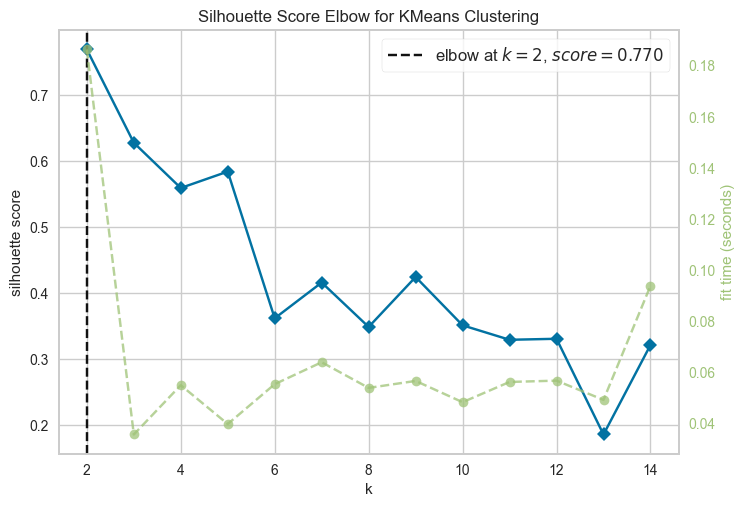

In [9]:
# instanciamos la clase de clustering
df_copia2 = df_scaled2.copy()
modelos = s_clustering.Clustering(df_copia2)

# sacamos el número de clusters óptimos para hacer el Kmeans 
modelos.sacar_clusters_kmeans()

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
km_fit = kmeans.fit(df_copia2)
labels = km_fit.labels_
df_copia2["clusters_kmeans"] = labels.astype(str)


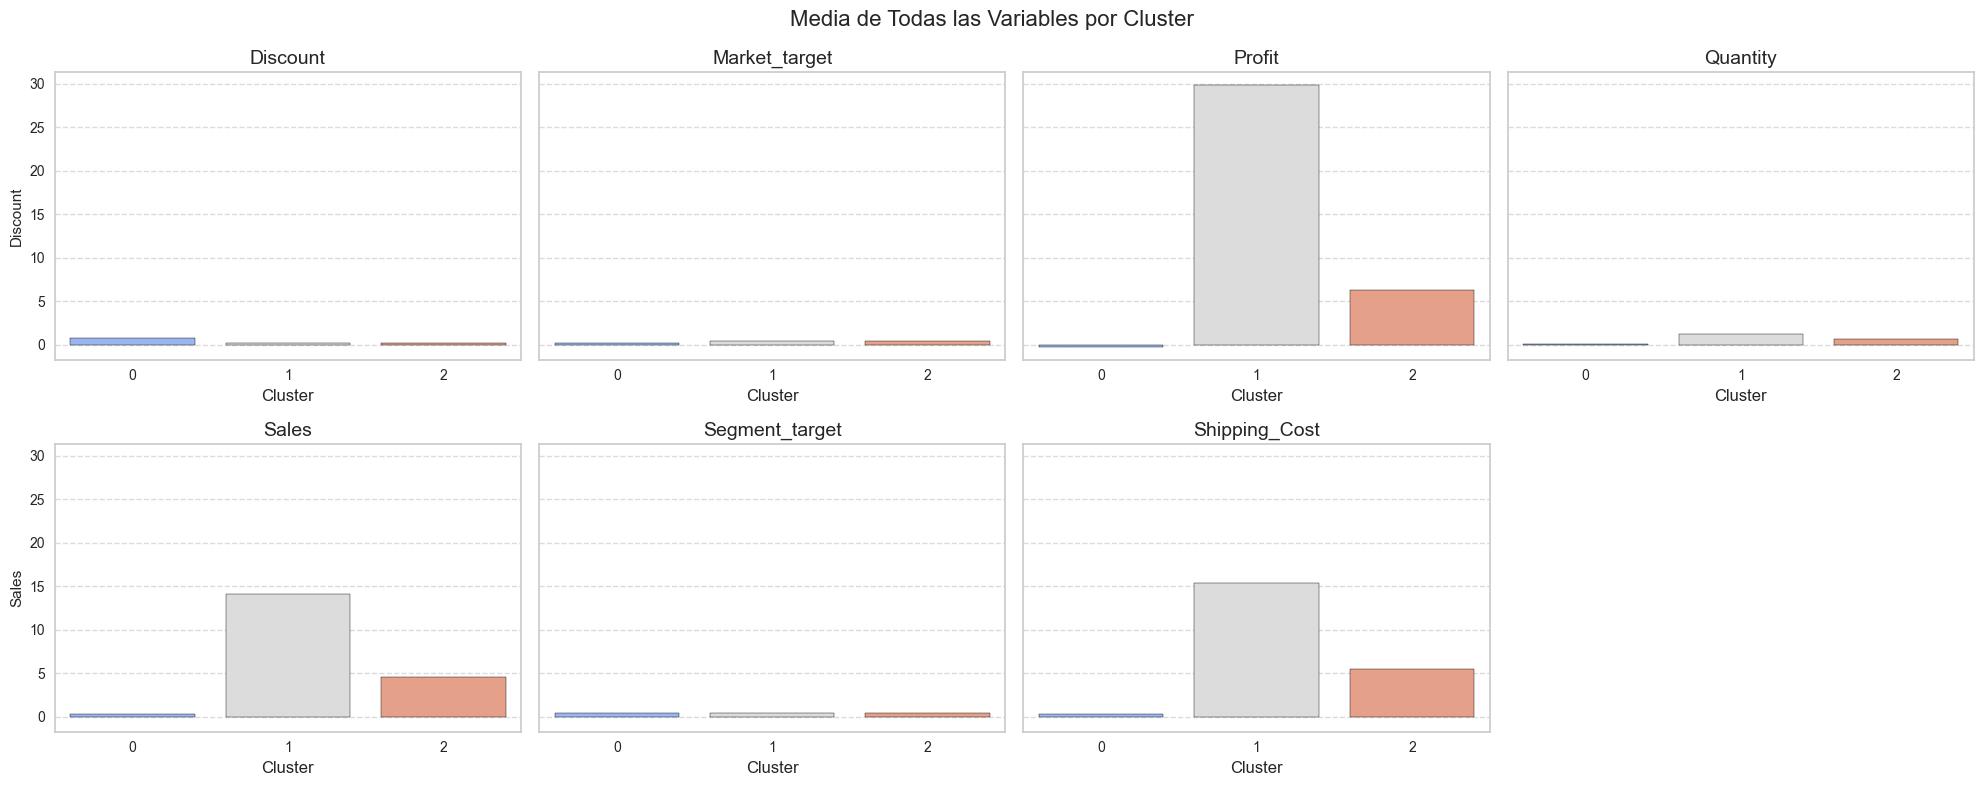

In [11]:
df_kmeans = df_copia2.copy()
# Seleccionar todas las columnas excepto 'country' y agrupar por 'cluster'
columns_to_include = df_kmeans.columns  # Excluye 'country'
variables = columns_to_include.difference(['clusters_kmeans'])  # Variables numéricas
cluster_means = df_kmeans.groupby('clusters_kmeans')[variables].mean().reset_index()

# Crear el subplot dinámicamente
num_vars = len(variables)
fig, axes = plt.subplots(nrows = 2, ncols = math.ceil(num_vars/ 2), figsize=(20,8), sharey=True)
axes = axes.flat
# Generar un barplot para cada variable en un subplot
for i, variable in enumerate(variables):
    sns.barplot(
        data=cluster_means,
        x='clusters_kmeans',
        y=variable,
        ax=axes[i],
        palette='coolwarm',
        edgecolor='black'
    )
    axes[i].set_title(f'{variable}', fontsize=14)
    axes[i].set_xlabel('Cluster', fontsize=12)

    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.delaxes(axes[-1])
# Título general del gráfico
fig.suptitle('Media de Todas las Variables por Cluster', fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
modelos = s_clustering.Clustering(df_copia2)
modelos.calcular_metricas(labels = labels)

,silhouette_score,davies_bouldin_index,cardinalidad
0,0.647326,0.846228,46720


In [17]:
df_kmeans.to_pickle("../datos/df_elegido.pkl")

In [14]:
df_dbscan = df_scaled2.copy()
modelos = s_clustering.Clustering(df_scaled2)
modelos.modelo_dbscan(df_dbscan)

eps: 0.5, min_samples: 3, silhouette: -0.21440653972559318
eps: 0.5, min_samples: 2, silhouette: -0.23845042710224928
eps: 0.5, min_samples: 1, silhouette: -0.1271840759030514
eps: 1.0, min_samples: 3, silhouette: -0.006584304395773475
eps: 1.0, min_samples: 2, silhouette: -0.09307845593366908
eps: 1.0, min_samples: 1, silhouette: -0.1858669861564514
eps: 1.5, min_samples: 3, silhouette: 0.42721916078018635
eps: 1.5, min_samples: 2, silhouette: 0.2324233661646222
eps: 1.5, min_samples: 1, silhouette: 0.06906743087742204


,Sales,Quantity,Discount,Profit,Shipping_Cost,Segment_target,Market_target,Sub-Category_target,clusters_dbscan
0,10.098283,1.333333,0.0,20.454890,42.389194,0.000000,0.000000,0.336874,-1
1,16.452253,2.000000,0.5,-8.095762,41.934066,1.000000,1.149992,0.871484,-1
2,23.105962,2.000000,0.5,24.741402,41.561355,0.000000,1.149992,1.067885,-1
3,12.744104,0.666667,0.5,-2.873676,41.317308,0.732496,0.765599,1.067885,-1
4,12.473784,1.666667,0.0,8.211899,40.991300,0.000000,-0.706204,1.538797,-1
...,...,...,...,...,...,...,...,...,...
51285,-0.090574,0.666667,0.0,-0.128769,-0.356227,1.000000,1.149992,-0.240840,11
51286,-0.384072,-0.666667,4.0,-0.281174,-0.356227,0.000000,0.000000,1.254701,11
51287,-0.282045,0.000000,0.0,0.054083,-0.356227,0.732496,0.000000,-0.142034,11
51288,-0.325078,-0.333333,0.0,-0.185819,-0.356685,0.732496,-0.234401,-0.128516,11


El silhouette no es bueno, tampoco D-B. Claramente hay un cluster "Cajón desastre" y hay muchos clusters como para sacar conclusiones. Volvemos a probar. Esta vez eliminamos market_target y segment_target

In [15]:
modelos.calcular_metricas(labels = df_dbscan["clusters_dbscan"])

,silhouette_score,davies_bouldin_index,cardinalidad
0,0.427219,2.279277,3


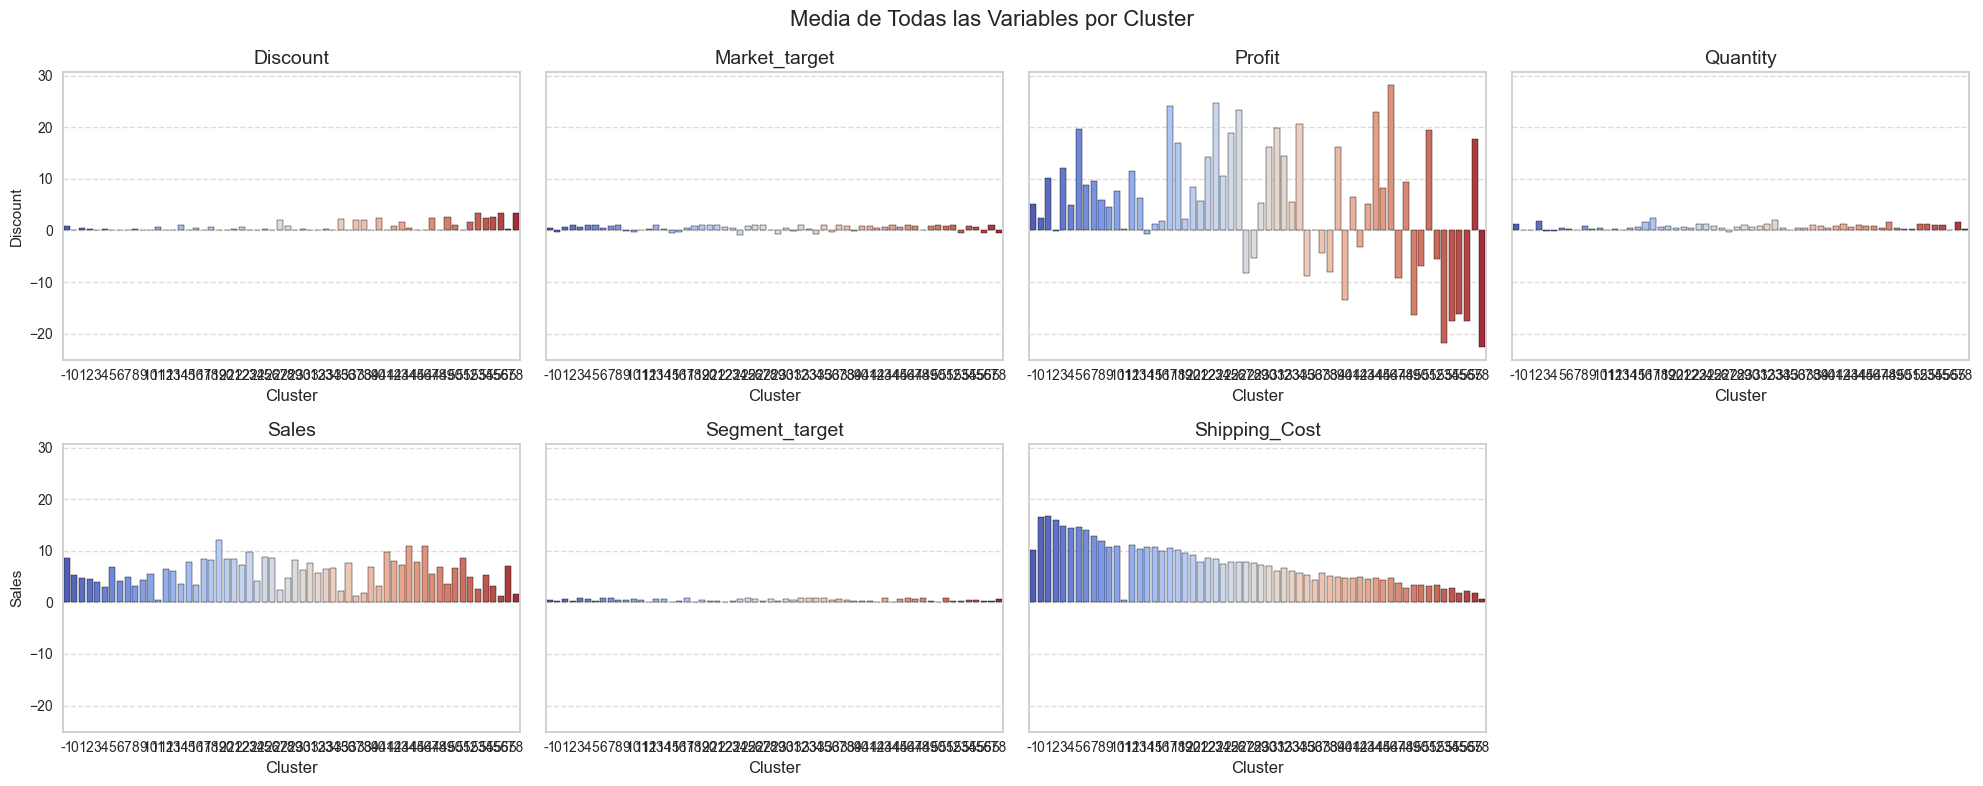

In [16]:
df_kmeans = df_dbscan.copy()
# Seleccionar todas las columnas excepto 'country' y agrupar por 'cluster'
columns_to_include = df_kmeans.columns  # Excluye 'country'
variables = columns_to_include.difference(['clusters_dbscan'])  # Variables numéricas
cluster_means = df_kmeans.groupby('clusters_dbscan')[variables].mean().reset_index()

# Crear el subplot dinámicamente
num_vars = len(variables)
fig, axes = plt.subplots(nrows = 2, ncols = math.ceil(num_vars/ 2), figsize=(20,8), sharey=True)
axes = axes.flat
# Generar un barplot para cada variable en un subplot
for i, variable in enumerate(variables):
    sns.barplot(
        data=cluster_means,
        x='clusters_dbscan',
        y=variable,
        ax=axes[i],
        palette='coolwarm',
        edgecolor='black'
    )
    axes[i].set_title(f'{variable}', fontsize=14)
    axes[i].set_xlabel('Cluster', fontsize=12)

    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.delaxes(axes[-1])
# Título general del gráfico
fig.suptitle('Media de Todas las Variables por Cluster', fontsize=16)
plt.tight_layout()
plt.show()